<a href="https://colab.research.google.com/github/Aviva-Chen/bertForClassification_/blob/main/Bert%2BSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
path='/content/gdrive/MyDrive/bertFolder'
os.chdir(path)
print(os.getcwd())

Mounted at /content/gdrive
/content/gdrive/MyDrive/bertFolder


In [ ]:
!pip3 install torchvision
!pip install transformers

In [ ]:
import pandas as pd
import torch
from sklearn.svm import SVC
from transformers import BertTokenizer, BertModel,AdamW,get_linear_schedule_with_warmup
import joblib
import random
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

#训练数据
x1=[]
y1=[]
x2=[]
y2=[]

df0= pd.read_excel("/content/gdrive/MyDrive/bertFolder/wholeDataset.xlsx",names=['title','label'])
print('finish loading')
df0 = shuffle(df0)
df1=df0[0:80000]
df2=df0[80000:160000]

train_data1=list(df1['title'])
for title in train_data1:
    x1.append(str(title))
y1=list(df1['label'])
print(len(x1))
train_data2=list(df2['title'])
for title in train_data2:
    x2.append(str(title))
y2=list(df2['label'])
print(len(x2))
x_test=[]
y_test=[]

df1=test_df=pd.read_excel('/content/gdrive/MyDrive/bertFolder/testSet.xlsx',sheet_name='Sheet3',names=['title given by machine','label'])
x=list(test_df['title given by machine'])

x_test=[str(i) for i in x]
y_test=list(test_df['label'])

#encoding data
from torch.utils.data import TensorDataset,Dataset,DataLoader,random_split, RandomSampler, SequentialSampler
class DataToDataset(Dataset):
    def __new__(cls,encoding,labels):
        return Dataset.__new__(cls)
    def __init__(self,encoding,labels):
        self.encoding=encoding
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,index):
        return self.encoding['input_ids'][index],self.encoding['attention_mask'][index],self.labels[index]
cuda=torch.cuda.is_available()
device=torch.device("cuda" if cuda else "cpu")


finish loading
80000
80000


In [ ]:
df1=df1.append(df2)
df1.to_excel(r'/content/gdrive/MyDrive/bertFolder/dataForSVM_16w.xlsx')

In [ ]:
from transformers.models.auto.configuration_auto import model_type_to_module_name
import numpy as np
from torch import nn

def getVector(x,y,device,model):

  max_length = 32
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  
  model.cuda()

  result = tokenizer(x, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
  labels=torch.tensor(y)
  dataset = DataToDataset(result,labels)
  
  data_loader=DataLoader(dataset=dataset,batch_size=32)
    
  list0=[] #存储向量
  for i,batch in enumerate(data_loader):
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)

      model.zero_grad()
            
      #last_hidden_states = model(input_ids, attention_mask=attention_mask)
      #feature_i= last_hidden_states[0][:, 0, :].detach().cpu().numpy()      
      #因为output_hidden_states默认为false，模型的输出是包含两个值的元组，第一个值代表隐藏状态，第二值包含[CLS]标记的嵌入表示
      xx,pooled_output = model(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
      #dropout=nn.Dropout(0.5)
      #dropout_output=dropout(pooled_output)
      feature_i=pooled_output.detach().cpu().numpy()

      for i in feature_i:            
        list0.append(i.tolist())
        #print(i.tolist())
        #print("-----")
      
  return list0

In [ ]:
def train_svm(x_train_vec, y_train):
    # C惩罚系数
    clf = SVC(C=1, kernel='rbf',  decision_function_shape='ovr')
    clf.fit(x_train_vec, y_train)
    # 封装模型
    print('保存模型...')
    joblib.dump(clf, '/content/gdrive/MyDrive/bertFolder/bert_svm128.pkl')
    return clf

from sklearn.decomposition import PCA

if __name__ == '__main__':
  model = BertModel.from_pretrained('bert-base-uncased')
  #model0 = torch.load("/content/gdrive/MyDrive/bertFolder/model1.pt",map_location=torch.device('cpu'))
  #model=model0.bert
  x_vec1= getVector(x1,y1,device,model)  
  x_test_vec=getVector(x_test,y_test,device,model)
  pca = PCA(n_components=128,whiten=False,svd_solver='auto')
  pca.fit(x_vec1)
  x_vec_new1 = pca.fit_transform(x_vec1)
  print("开始SVM！")
  x_vec2= getVector(x2,y2,device,model)
  print("x_vec2:ok")
  x_vec_new2=pca.transform(x_vec2)
  x_vec_new=list(x_vec_new1)+list(x_vec_new2)
  y=y1+y2
  
  clf=train_svm(x_vec_new,y)
  
  svm = joblib.load('/content/gdrive/MyDrive/bertFolder/bert_svm128.pkl')
  
  x_test_vec_new=pca.transform(x_test_vec)
  pred_labels = svm.predict(x_test_vec_new)

  from sklearn.metrics import matthews_corrcoef
  # Calculate the MCC
  mcc = matthews_corrcoef(y_test, pred_labels)

  print('Total MCC: %.3f' % mcc)

  print(classification_report(y_test, pred_labels,digits=3)) 

In [ ]:
s_data1 = pd.DataFrame({'x_vec1':x_vec1,'y1':y1})
s_data2 = pd.DataFrame({'x_vec2':x_vec2,'y2':y2})
s_data1.to_excel(r'/content/gdrive/MyDrive/bertFolder/x_vec1.xlsx')
s_data2.to_excel(r'/content/gdrive/MyDrive/bertFolder/x_vec2.xlsx')

In [ ]:
pca = PCA(n_components=256,whiten=False,svd_solver='auto')
pca.fit(x_vec1)
x_vec_new1 = pca.fit_transform(x_vec1)
x_vec_new2=pca.transform(x_vec2)
x_vec_new=list(x_vec_new1)+list(x_vec_new2)
y=y1+y2
clf=train_svm(x_vec_new,y)
  
svm = joblib.load('/content/gdrive/MyDrive/bertFolder/bert_svm0.pkl')
  
x_test_vec_new=pca.transform(x_test_vec)
pred_labels = svm.predict(x_test_vec_new)
from sklearn.metrics import matthews_corrcoef
 # Calculate the MCC
mcc = matthews_corrcoef(y_test, pred_labels)

print('Total MCC: %.3f' % mcc)

print(classification_report(y_test, pred_labels,digits=3)) 

In [ ]:
pca = PCA(n_components=352,whiten=False,svd_solver='auto')
pca.fit(x_vec1)
x_vec_new1 = pca.fit_transform(x_vec1)
x_vec2= getVector(x2,y2,device,model)
x_vec_new2=pca.transform(x_vec2)
x_vec_new=list(x_vec_new1)+list(x_vec_new2)
y=y1+y2
clf=train_svm(x_vec_new,y)
  
svm = joblib.load('/content/gdrive/MyDrive/bertFolder/bert_svm0.pkl')
  
x_test_vec_new=pca.transform(x_test_vec)
pred_labels = svm.predict(x_test_vec_new)
from sklearn.metrics import matthews_corrcoef
 # Calculate the MCC
mcc = matthews_corrcoef(y_test, pred_labels)

print('Total MCC: %.3f' % mcc)

print(classification_report(y_test, pred_labels,digits=3)) 

In [ ]:
print(len(x_vec_new2))
print(len(y))

60000
120000


In [ ]:
model0 = torch.load("/content/gdrive/MyDrive/bertFolder/model1.pt",map_location=torch.device('cpu'))
model=model0.bert
x_test_vec=getVector(x_test,y_test,device,model)

In [ ]:
from sklearn import manifold
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

tsne=manifold.TSNE(n_components=3,init='pca',random_state=501)
x_vec=np.array(x_test_vec)
s_lowWeights=tsne.fit_transform(x_vec)
trueLabels=np.array(y_test)
trueLabels=trueLabels.reshape((-1,1))

s_data=np.hstack((s_lowWeights,trueLabels))
s_data = pd.DataFrame({'x': s_data[:, 0], 'y': s_data[:, 1],'z': s_data[:, 2], 'label': s_data[:, 3]})
print(s_data)

In [ ]:
def visual(x):
    tsne=manifold.TSNE(n_components=3,init='pca',random_state=501)
    x_tsne=tsne.fit_transform(x)
    #print(x_tsne)
    print("Orginal data dimension is {}. Embedded data dimension is {}".format(x.shape[-1], x_tsne.shape[-1]))

    #嵌入空间可视化
    x_min,x_max=x_tsne.min(0),x_tsne.max(0)
    x_norm=(x_tsne-x_min)/(x_max-x_min)
    
    return x_norm

x_vec=np.array(x_test_vec)
y=np.array(y_test)

s_lowWeights=visual(x_vec)
trueLabels=y

#降到2维以后的特征分别赋给x,y轴
trueLabels=trueLabels.reshape((-1,1))

s_data=np.hstack((s_lowWeights,trueLabels))
#二维
#s_data = pd.DataFrame({'x': s_data[:, 0], 'y': s_data[:, 1], 'label': s_data[:, 2]})
#三维
s_data = pd.DataFrame({'x': s_data[:, 0], 'y': s_data[:, 1],'z': s_data[:, 2], 'label': s_data[:, 3]})

X=list(s_data['x'])
Y=list(s_data['y'])
Z=list(s_data['z'])
label=list(s_data['label'])
 
X0,Y0,Z0=[],[],[]
X1,Y1,Z1=[],[],[]
#data:dataFrame
for i in range(1000):
  #label[i]:str
  if int(label[i])==0:
    #print(X[i],Y[i])
    X0.append(float(X[i]))
    Y0.append(float(Y[i]))
    Z0.append(float(Z[i]))
  elif int(label[i])==1:
    X1.append(float(X[i]))
    Y1.append(float(Y[i]))
    Z1.append(float(Z[i]))

fig = plt.figure()
ax = plt.subplot(111, projection='3d')

p1 = ax.scatter(X0,Y0,Z0, marker='.', color='black', s=15)
p2 = ax.scatter(X1,Y1,Z1, marker='.', color='red', s=15)

plt.show()

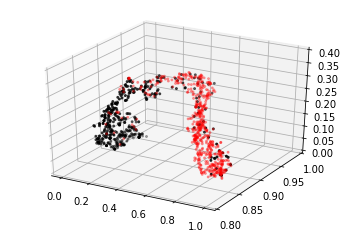

In [ ]:
fig = plt.figure()
ax = plt.subplot(111, projection='3d')

p1 = ax.scatter(X0,Z0,Y0, marker='.', color='black', s=15)
p2 = ax.scatter(X1,Z1,Y1, marker='.', color='red', s=15)
plt.ylim(0.8,1)
ax.set_zlim3d(0,0.4)
#plt.xticks([])
plt.yticks([0.80,0.85,0.9,0.95,1])

plt.show()

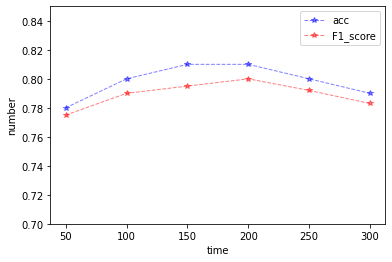

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_axis_data = [50,100,150,200,250,300] #x
y_axis_data1 = [0.78,0.80,0.81,0.81,0.80,0.79] #y
y_axis_data2 = [0.775,0.790,0.795,0.800,0.792,0.783] #y

plt.plot(x_axis_data, y_axis_data1, 'b*--', alpha=0.5, linewidth=1, label='acc')
plt.plot(x_axis_data, y_axis_data2, 'r*--', alpha=0.5, linewidth=1, label='F1_score')
#'bo-'表示蓝色实线，数据点实心原点标注
## plot中参数的含义分别是横轴值，纵轴值，线的形状（'s'方块,'o'实心圆点，'*'五角星   ...，颜色，透明度,线的宽度和标签 ，

plt.legend()  #显示上面的label
plt.ylim(0.7,0.85)
plt.xlabel('time') #x_label
plt.ylabel('number')#y_label
 
#plt.ylim(-1,1)#仅设置y轴坐标范围
plt.show()